# Проект-3. Использование EDA для предсказания рейтинга отелей.

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import category_encoders as ce
import nltk
import warnings
import plotly.io as pio
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [14]:
warnings.filterwarnings('ignore')
nltk.downloader.download('vader_lexicon')
pio.renderers.default = 'png'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sadeyes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
hotels_train = pd.read_csv('data/hotels.csv')
hotels_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [4]:
hotels_train['sample'] = 1
hotels_test['sample'] = 0
hotels_test['reviewer_score'] = 0

In [5]:
hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

Посмотрим на тип данных.

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропущенные значения в признаках.

In [7]:
hotels.isnull().sum().sort_values(ascending=False)

lng                                           3268
lat                                           3268
hotel_address                                    0
additional_number_of_scoring                     0
sample                                           0
days_since_review                                0
tags                                             0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
positive_review                                  0
total_number_of_reviews                          0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
reviewer_score                                   0
dtype: int64

## Добавим признак страны отеля и информацию о населении в стране каждого отеля

Посмотрим на пример строк из признака hotel_address, чтобы выделить оттуда важную информацию и увидеть структуру строк.

In [8]:
for i in range(0, 10, 2):
    display(hotels['hotel_address'].iloc[i])

'Via Senigallia 6 20161 Milan Italy'

'Mallorca 251 Eixample 08008 Barcelona Spain'

'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands'

'Empire Way Wembley Brent London HA9 8DS United Kingdom'

'35 Rue Caumartin 9th arr 75009 Paris France'

Возьмем таблицу с Википедии о названии всех стран и соотношение населения к общему населению планеты.

In [9]:
countries_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population')[1]
total_population = countries_info['Population']['Numbers'].iloc[0]
countries_info['% of the world'] = countries_info['Population']['Numbers'] #/ total_population * 100).round(2)
countries_info = countries_info.sort_index(axis=1).drop(
    columns=['Date', 'Notes', 'Source (official or from the\xa0United Nations)', 'Rank', 'Population'],
    index=0).droplevel(level=1, axis=1).rename(
    columns={'% of the world': 'population_ratio',
             'Country / Dependency': 'country'}).sort_index(axis=1)
countries_info.head()

,country,population_ratio
1,China,1411750000
2,India,1375586000
3,United States,334387067
4,Indonesia,275773800
5,Pakistan,235825000


Создадим признак *country*, в котором будет информация о стране, в которой располагается отель.

In [10]:
def get_country(address:str) -> str:
    
    """Returns existing country for raw address. If the country was not found, then returns none 

    Args:
        address (str): Raw address

    Returns:
        str: One of the existing countries
    """
    
    for country in countries_info['country'].to_list():
        if country in address:
            return country

hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels = hotels.join(countries_info.set_index('country'), on='country')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,58887359
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,17797060
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,47615034


## Анализ каждого числового признака из оригинального датасета.

Выделим все числовые признаки в отдельный датафрейм, чтобы было удобнее их анализировать.

In [11]:
num_features = hotels[[col for col in hotels.columns if hotels[col].dtype != 'object']].drop(columns=['lat', 'lng'])
num_features.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,population_ratio
0,904,8.1,52,16670,62,1,0,0.0,58887359
1,612,8.6,10,5018,0,7,0,0.0,17797060
2,46,8.3,3,351,5,15,0,0.0,47615034
3,241,9.1,0,1543,27,9,0,0.0,58887359
4,834,9.1,0,4687,7,2,0,0.0,17797060


Будем изучать каждый признак с помощью соответствующих графиков и пояснений к нему.

### *additional_number_of_scoring*

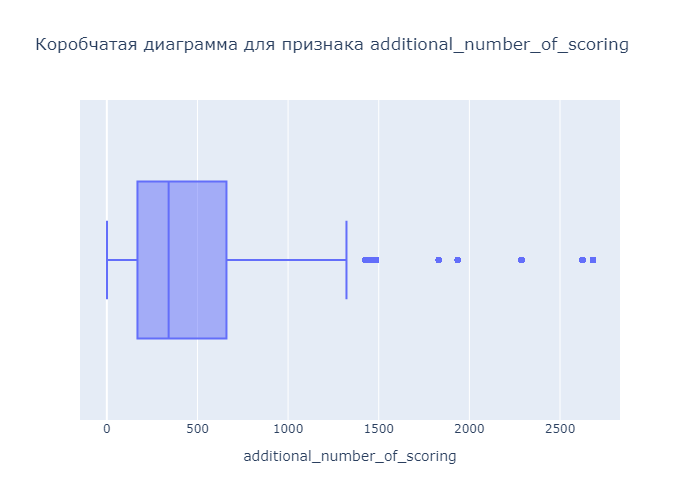

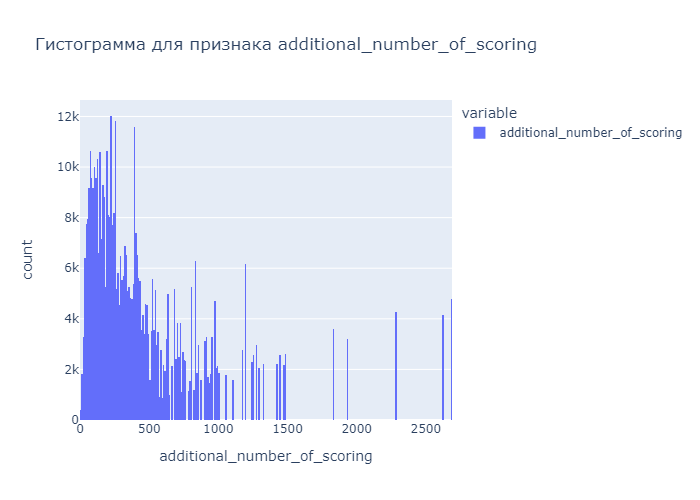

In [23]:
additional_scoring_box = px.box(
    x=num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака additional_number_of_scoring',
    labels={'x': 'additional_number_of_scoring'}
)
additional_scoring_hist = px.histogram(
    num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Гистограмма для признака additional_number_of_scoring',
    labels={'value': 'additional_number_of_scoring'}
)
additional_scoring_box.show()
additional_scoring_hist.show()

По коробчатой диаграмме можно подумать, что тут есть аномальные значения(выбросы), который необходимо удалить, но гистограмма говорит об обратном - значения признака выше 1500 встречаются не так уж редко, чтобы называть их выбросами.

### *average_score*

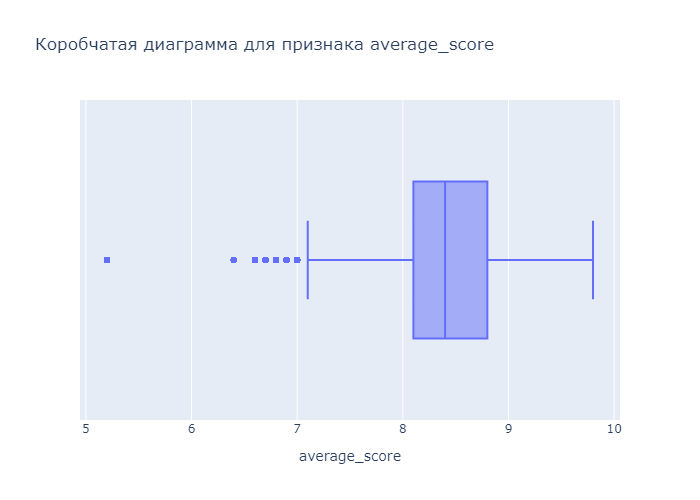

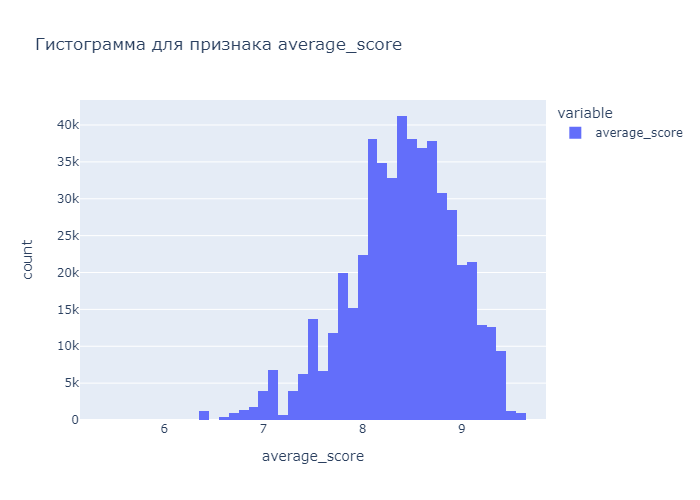

In [35]:
average_score_box = px.box(
    x=num_features['average_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака average_score',
    labels={'x': 'average_score'}
)
average_score_hist = px.histogram(
    num_features['average_score'],
    height=500,
    width=700,
    title='Гистограмма для признака average_score',
    labels={'value': 'average_score'}
)
average_score_box.show()
average_score_hist.show()

*average_score* тоже не нуждается в очистке, большинство данных распределено нормально, аномальные значения не наблюдаются.

### *review_total_negative_word_counts*

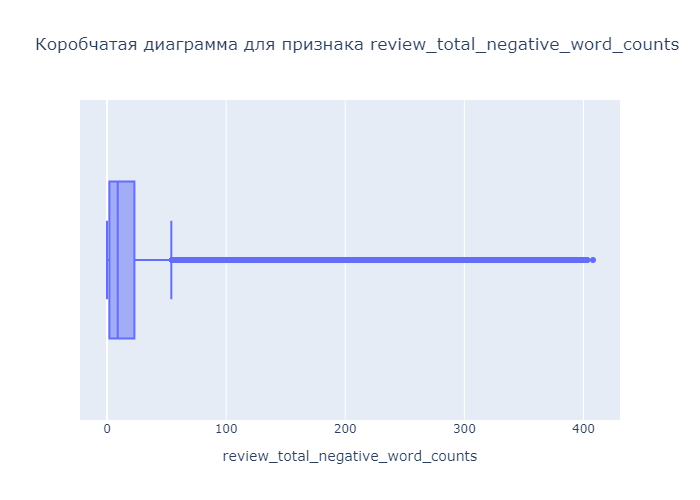

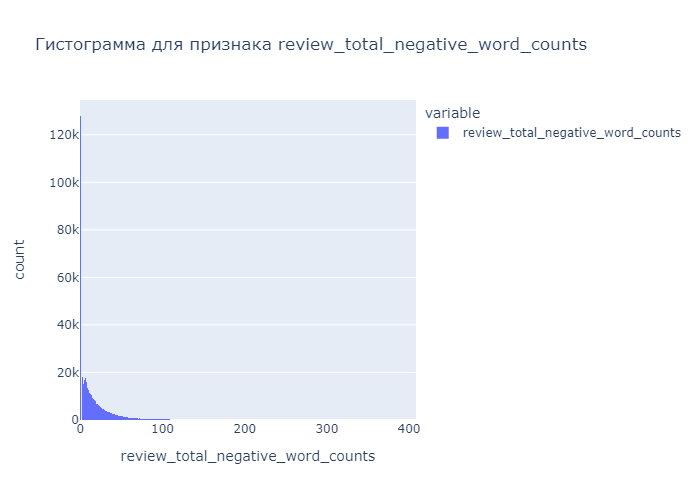

In [37]:
total_negative_box = px.box(
    x=num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_negative_word_counts',
    labels={'x': 'review_total_negative_word_counts'}
)
total_negative_hist = px.histogram(
    num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_negative_word_counts',
    labels={'value': 'review_total_negative_word_counts'}
)
total_negative_box.show()
total_negative_hist.show()

In [40]:
# Посмотрим, сколько записей имеют более 100 негативных слов в отзыве
num_features[num_features['review_total_negative_word_counts'] > 100].shape[0]

11637

Данный признак имеет логнормальное распределение. Чаще всего количество негативных слов = 0. Думаю, этот признак довольно важен, т.к. может напрямую влиять на целевую переменную рейтинга. Больше негативных слов -> хуже рейтинг. И наоборот. Оставим в таком виде

### *total_number_of_reviews*

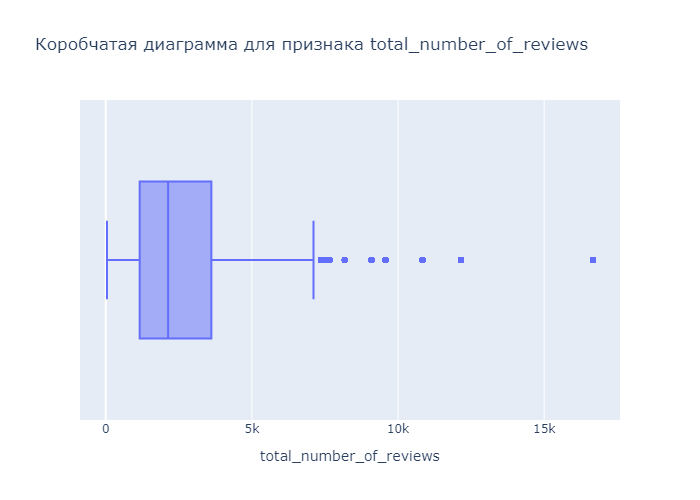

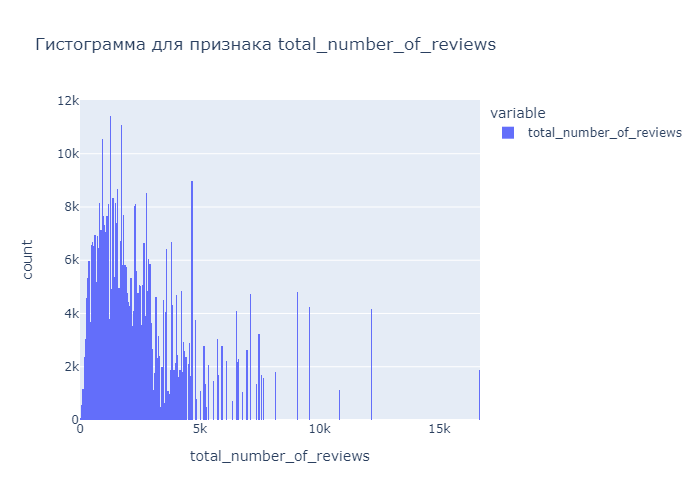

In [41]:
total_reviews_box = px.box(
    x=num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака total_number_of_reviews',
    labels={'x': 'total_number_of_reviews'}
)
total_reviews_hist = px.histogram(
    num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Гистограмма для признака total_number_of_reviews',
    labels={'value': 'total_number_of_reviews'}
)
total_reviews_box.show()
total_reviews_hist.show()

*total_number_of_reviews* также похож на признак с логнормальным распределением. У большинства отелей количество отзывов не превышает 5000, но всегда есть наиболее популярные и те, которые существуют довольно давно, поэтому выше 15000 отзывов - вполне логичное значение для подобных отелей. Оставляем признак как есть.

### *review_total_positive_word_counts*

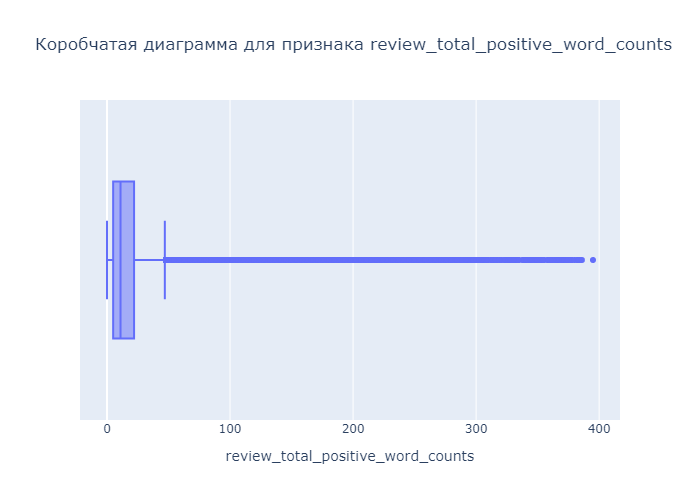

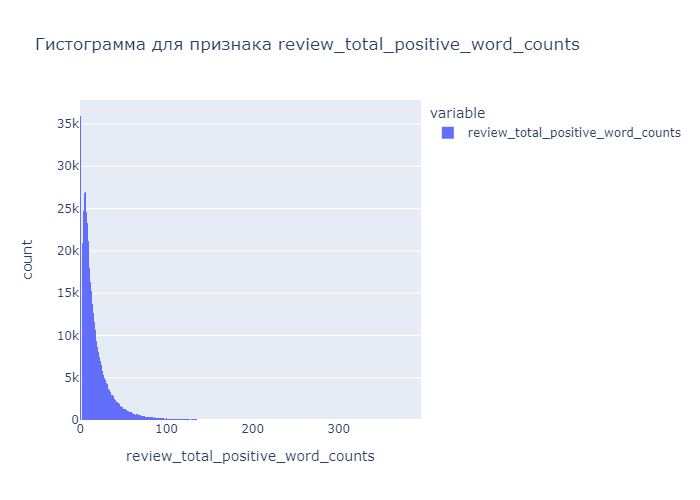

In [42]:
total_positive_box = px.box(
    x=num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_positive_word_counts',
    labels={'x': 'review_total_positive_word_counts'}
)
total_positive_hist = px.histogram(
    num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_positive_word_counts',
    labels={'value': 'review_total_positive_word_counts'}
)
total_positive_box.show()
total_positive_hist.show()

Данный признак аналогичен признаку *review_total_negative_word_counts* по смыслу, но отображает количество позитивных слов в отзыве.

### *total_number_of_reviews_reviewer_has_given*

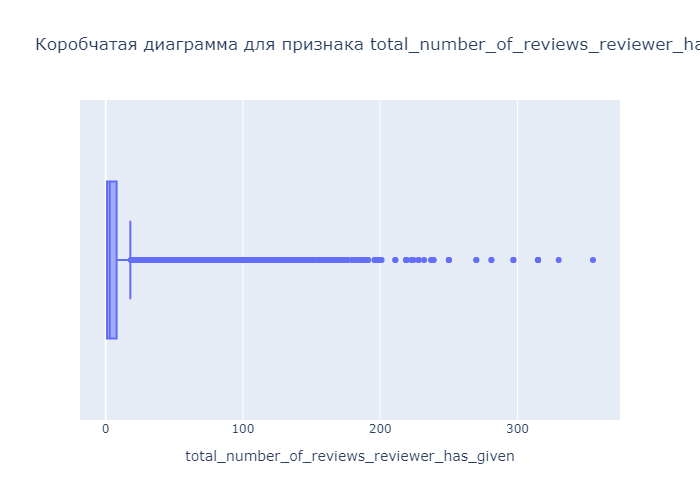

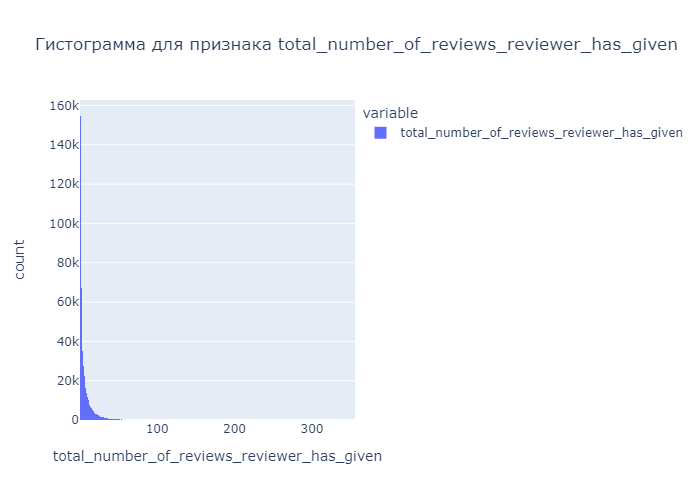

In [43]:
total_given_box = px.box(
    x=num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'x': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_hist = px.histogram(
    num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=700,
    title='Гистограмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'value': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_box.show()
total_given_hist.show()

Данный признак можно интерпретировать как "надёжность ревьювера". Чем больше отзывов оставил ревьювер - тем выше шанс, что его отзывы будут объективны, т.к. человек довольно ответственно подходит к этому занятию - оставлять отзыв к чему-либо.

### *reviewer_score* (целевой признак)

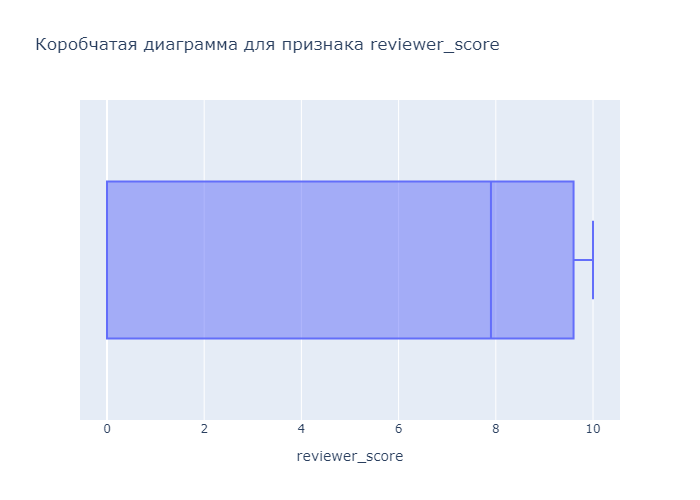

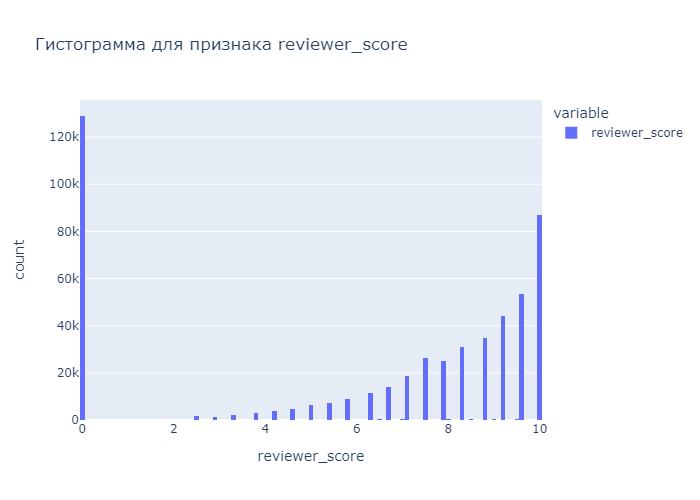

In [44]:
target_box = px.box(
    x=num_features['reviewer_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака reviewer_score',
    labels={'x': 'reviewer_score'}
)
target_hist = px.histogram(
    num_features['reviewer_score'],
    height=500,
    width=700,
    title='Гистограмма для признака reviewer_score',
    labels={'value': 'reviewer_score'}
)
target_box.show()
target_hist.show()

Нули - заполненные нами вручную значения для предсказания, поэтому их не учитываем. Отрицательных значений не наблюдается, выше 10 - тоже нет. Можно сказать, что выбросов и аномальных значений нет в данном признаке. Однако это далеко не означает то, что все оценки проставленны объективно и справедливо.

## Заполняем пропущенные значения координат с помощью `geopy`

Посмотрим, в каких странах есть пропущенные значения.

In [45]:
countries_with_null = hotels[hotels['lat'].isna() | hotels['lng'].isna()]['country'].value_counts()
countries_with_null

Austria    2679
France      382
Spain       207
Name: country, dtype: int64

Можно заметить, что больше всего пропущенных значений находится в Австрии, а также есть во Франции и Испании.

Посмотрим на структуру адресов в этих странах, чтобы было проще заполнять пустые значения.

In [46]:
for country in countries_with_null.index:
    display(hotels[(hotels['lat'].isna() | hotels['lng'].isna()) 
                   & (hotels['country'] == country)].iloc[0].loc['hotel_address'])

'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'

'23 Rue Damr mont 18th arr 75018 Paris France'

'Bail n 4 6 Eixample 08010 Barcelona Spain'

Видно, что последние 3 значения в строке представляют собой структуру *[postal code + city + country]*. Можем воспользоваться этой особенностью и заполнить пропущенные координаты с помощью библиотеки `geopy`.

Создадим отдельный датафрейм, который будет содержать в себе адрес, широту и долготу. Пропущенные значения заменим на строку, чтобы можно было заполнить эти значения с помощью метода `apply`, т.к. этот метод не работает с пропущенными (`NaN/None`) значениями.

In [47]:
address_coords = hotels[['hotel_address', 'lat', 'lng']].copy()
address_coords.fillna('unknown', inplace=True)
address_coords.head()

,hotel_address,lat,lng
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


Отобразим, как выглядят на данном этапе наши пропущенные значения, а потом сравним их после преобразования.

In [48]:
null_indexes = address_coords[address_coords['lat'] == 'unknown'].index
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,unknown,unknown
526,23 Rue Damr mont 18th arr 75018 Paris France,unknown,unknown
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,unknown,unknown
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515439,4 rue de la P pini re 8th arr 75008 Paris France,unknown,unknown
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown


Посмотрим на количество уникальных адресов.

In [49]:
address_coords.iloc[null_indexes]['hotel_address'].nunique()

17

Количество уникальных пропущенных адресов невелико, поэтому будем использовать запрос к [OpenStreetMap](https://www.openstreetmap.org/) с помощью библиотеки `geopy`.

In [50]:
# Создадим экземпляр класса Nominatim библиотеки geopy
geolocator = Nominatim(user_agent='project_3')
# Создадим экземпляр класса RateLimiter, чтобы ограничить задержку между запросами. В данном случае выполнение ячейки займет ~17 секунд
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the address

    Args:
        address (str): Address

    Returns:
        tuple: (latitude, longitude)
    """
    
    # Сократим адрес до формата {почтовый индекс + город + страна}, т.к. в "сыром" формате библиотека geopy может не распознать местоположение
    def get_short_address(address:str) -> str:
        
        """Returns address in format '%postal_code %city %country'
        
        Args:
            address (str): Raw format of address, where last 3 words is '%postal_code %city %country'
            
        Returns:
            str: Short address
        """
        
        short_address = ' '.join(address.split()[-3:])
        return short_address
    
    location = geocode(get_short_address(address))
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

unique_null_addresses = address_coords.iloc[null_indexes]['hotel_address'].unique()
# Создадим словарь, где ключем будет полный адрес, а значением - кортеж из широты и долготы
filled_addresses_dict = dict()
for address in unique_null_addresses:
    filled_addresses_dict[address] = get_coords(address)

Мы создали словарь из 17 различных адресов(все из них имеют пропущенные значения широты и долготы), где значениями является кортеж (широта, долгота). Теперь надо заполнить наши пропущенные значения с помощью этого словаря.

In [51]:
def fill_coords(address:str, lat, lng, dictionary:dict) -> tuple:
    
    """Returns the latitude and longitude value for the address key. It is recommended to use in combination with the pandas.apply() method

    Args:
        address (str): Address
        lat (any): Empty latitude column to fill
        lng (any): Empty longitude column to fill
        dictionary (dict): Dictionary to fill in latitude and longitude 

    Returns:
        tuple: (address, new latitude, new longitude)
    """
    
    lat = dictionary[address][0]
    lng = dictionary[address][1]
    
    return address, lat, lng

address_coords.iloc[null_indexes] = address_coords.iloc[null_indexes].apply(
    lambda row: fill_coords(row['hotel_address'], row['lat'], row['lng'], filled_addresses_dict),
    axis=1,
    result_type='broadcast'
)

Выведем строки, которые были пустыми, после того, как получили их координаты.

In [52]:
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.222757,16.356334
526,23 Rue Damr mont 18th arr 75018 Paris France,48.889485,2.342177
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.211029,16.347425
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515439,4 rue de la P pini re 8th arr 75008 Paris France,48.873751,2.314978
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042


Заменим пустые значения координат в нашем основном датафрейме на преобразованные. Теперь у нас нет пропусков в данных.

In [53]:
filled_coords = address_coords[['lat', 'lng']].copy()
hotels[['lat', 'lng']] = filled_coords
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
population_ratio                              0
dtype: int64

Теперь нам больше не нужен признак с полным адресом отеля.

In [54]:
hotels.drop(columns='hotel_address', inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,58887359
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,17797060
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.16152,0,0.0,Spain,47615034


## Добавим признак с информацией о столице страны, в которой находится отель.

Возьмем таблицу столиц с Википедии. Добавим для каждой столицы широту и долготу.

In [55]:
capitals_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals')[1]
capitals_df.drop(columns='Notes', axis=1, inplace=True)
capitals_df = capitals_df[capitals_df['Country/Territory'].isin(hotels['country'].unique())]
capitals_df = capitals_df.rename(columns={
    'City/Town': 'capital',
    'Country/Territory': 'country'
}).drop(index=13) # Удалим неофициальную столицу Нидерландов
capitals_df[['lat_cap', 'lng_cap']] = 'unknown'
# Удалим лишнюю информацию из названия столицы, например, приписку (official) 
capitals_df['capital'] = capitals_df['capital'].apply(lambda x: x.split()[0])
# Название города совпадает с названием страны, добавим уточнение для geopy, что Mexico в столбце capital - это город
capitals_df.loc[150]['capital'] = 'Mexico city' 
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,unknown,unknown
134,London,United Kingdom,unknown,unknown
138,Madrid,Spain,unknown,unknown
150,Mexico city,Mexico,unknown,unknown
180,Paris,France,unknown,unknown
199,Rome,Italy,unknown,unknown
248,Vienna,Austria,unknown,unknown


Заполним значения координат для столиц немного измененной функцией из раздела заполнения пропущенных значений.

In [56]:
def get_capital_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the city

    Args:
        address (str): City name

    Returns:
        tuple: (latitude, longitude)
    """
    
    location = geocode(address)
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

capital_coords = dict()
for capital in capitals_df['capital'].values:
    capital_coords[capital] = get_capital_coords(capital)

capitals_df[['capital', 'lat_cap', 'lng_cap']] = capitals_df[['capital', 'lat_cap', 'lng_cap']].apply(
    lambda row: fill_coords(row['capital'], row['lat_cap'], row['lng_cap'], capital_coords),
    axis=1,
    result_type='broadcast'
)
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,52.37308,4.892453
134,London,United Kingdom,51.507322,-0.127647
138,Madrid,Spain,40.416705,-3.703582
150,Mexico city,Mexico,19.43263,-99.133178
180,Paris,France,48.85889,2.320041
199,Rome,Italy,41.89332,12.482932
248,Vienna,Austria,48.208354,16.372504


Присоединим к основному датафрейму данные о столицах.

In [57]:
hotels = hotels.join(capitals_df.set_index('country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio,capital,lat_cap,lng_cap
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,45.533137,9.171102,0,0.0,Italy,58887359,Rome,41.89332,12.482932
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,52.385649,4.834443,0,0.0,Netherlands,17797060,Amsterdam,52.37308,4.892453
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,616 day,41.393192,2.16152,0,0.0,Spain,47615034,Madrid,40.416705,-3.703582


## Посчитаем расстояние между расположением отеля и столицей страны

Напишем функцию, которая будет для каждой строки считать расстояние(в километрах) между координатами отеля и координатами столицы страны. Используем функциональность библиотеки `geopy`. Удалим признаки широты и долготы, т.к. это координаты и они не несут в себе смысла, ровно как и столбцы с любыми id. А также удалим название столицы, т.к. оно тоже не несёт в себе смысла и мы использовали его исключительно для того, чтобы получить координаты и посчитать расстояние.

In [58]:
def get_distance(lat_1:float, lng_1:float, lat_2:float, lng_2:float) -> float:
    
    """Returns distance between coordinates of 2 cities using 

    Args:
        lat_1 (float): latitude of first city
        lng_1 (float): longitude of first city
        lat_2 (float): latitude of second city
        lng_2 (float): longitude of second city

    Returns:
        float: Distance between 2 cities in kilometres
    """
    
    first_city = (lat_1, lng_1)
    second_city = (lat_2, lng_2)
    return np.round(geodesic(first_city, second_city).km, 0)
    
hotels['distance_to_capital'] = hotels[['lat', 'lng', 'lat_cap', 'lng_cap']].apply(
    lambda row: get_distance(row['lat'], row['lng'], row['lat_cap'], row['lng_cap']),
    axis=1
)
hotels.drop(columns=['lat', 'lng', 'lat_cap', 'lng_cap', 'capital'], inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population_ratio,distance_to_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58887359,484.0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17797060,4.0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,47615034,506.0


Так как мы считали расстояние до центра столицы, то можем создать следующий бинарный признак: находится ли отель в пределах столицы или нет. Обычно столицы - большие города. Условимся, что если расстояние до центра столицы составляет более 50 км - значит отель находится в другом городе. 

In [59]:
# Отдалённость от столицы
distance = 50
hotels['is_capital'] = hotels['distance_to_capital'].apply(
    lambda distance_to_capital: int(distance_to_capital <= distance)
)
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population_ratio,distance_to_capital,is_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58887359,484.0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17797060,4.0,1


## Преобразование отзывов

Далеко не все негативные отзывы мы можем назвать "истинно негативными". Например, человек может написать "всё хорошо" или "нет претензий" или вообще оставить пустую строку в разделе для негативных отзывов, при этом данный отзыв де-факто не будет являться негативным. Попытаемся уменьшить количество таких отзывов, сделав их нейтральными.

In [60]:
reviews = hotels[['negative_review', 'positive_review']]
reviews.head()

,negative_review,positive_review
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...
1,No tissue paper box was present at the room,No Positive
2,Pillows,Nice welcoming and service
3,No Negative,Everything including the nice upgrade The Hot...
4,No Negative,Lovely hotel v welcoming staff


Взглянем на топ-15 негативных отзывов и убедимся в утверждении выше. Большинство отзывов не имеют в себе негативного подтекста.

In [61]:
reviews['negative_review'].value_counts().head(15)

No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: negative_review, dtype: int64

Теперь посмотрим, как анализатор текста воспринимает строку *«No Negative»*, которая для человека как минимум означает нейтральность. К тому же, в английском языке не принято говорить *«Мне ничего не понравилось»* в дословном переводе с русского. Обычно говорят *«Мне всё не понравилось»*(*«I didn't like anything»* и прочие вариации), тогда негативный отзыв *«Nothing»* не будет означать то же, что и в дословном переводе на русский *«Мне ничего не понравилось»*.

In [62]:
# Создадим класс библиотеки nltk, передадим в метод строку, чтобы узнать скоринг слов в этой строке
sent_analyzer = SentimentIntensityAnalyzer()
sent_analyzer.polarity_scores('No Negative')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

Напишем функцию, чтобы уменьшить количество таких случаев и свести их к нейтральности. Снова взглянем на новый топ-15 негативных отзывов.

In [63]:
def analyze_negative(review:str):
    review_to_check = review.lower()
    neutral_sentences = ['no negative', 'nothing', 'n a', 'na', 'none', 'no complaints', 'non', 'no', 'nil']
    
    for neutral in neutral_sentences:
        # Проверяем вхождение слов только в короткие строки, состоящие из 3 и менее слов
        if review_to_check.isspace() or (len(review_to_check.split()) <= 3 and neutral in review_to_check):
            return 'neutral'        
    return review
        
reviews['negative_review'] = reviews['negative_review'].copy().apply(analyze_negative)
reviews['negative_review'].value_counts().head(15)

neutral                      164201
 Breakfast                      407
 Small room                     373
 Location                       368
 Everything                     326
 All good                       318
 Price                          260
 Small rooms                    188
 All good                       152
 Expensive                      142
 Room size                      140
 Can t think of anything        138
 Staff                          130
 Everything was perfect         129
 Very small room                120
Name: negative_review, dtype: int64

Теперь негативные отзывы стали более точно передавать их смысл, а анализатор текста с более высокой точностью определит соотношение негативных, нейтральных и позитивных слов.

Перейдём к положительным отзывам с той же проблемой. «No Positive» нельзя интерпретировать как «Плохой», потому что оба поля с негативными и позитивными отзывами могут быть пустыми(или оба заполнены такими нейтральными словами). В таком случае у нас оба предложения должны иметь нейтральный подтекст. Если же в негативном отзыве будет написано что-то плохое, то анализатор текста увеличит скоринг негативных слов и выдаст более точный результат.

In [64]:
reviews['positive_review'].value_counts().head(15)

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
Name: positive_review, dtype: int64

In [65]:
def analyze_positive(review:str):
    review_to_check = review.lower()
    neutral_sentences = ['no positive', 'nothing', 'n a', 'na', 'none', 'non', 'no', 'nil']
    
    for neutral in neutral_sentences:
        if review_to_check.isspace() or (len(review_to_check.split()) <= 3 and neutral in review_to_check):
            return 'neutral'        
    return review
    
        
reviews['positive_review'] = reviews['positive_review'].copy().apply(analyze_positive)
reviews['positive_review'].value_counts().head(15)

neutral                41821
 Location               9222
 Everything             2284
 location               1677
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 everything              319
Name: positive_review, dtype: int64

Теперь мы можем закодировать данные отзывы с помощью анализатора текста библиотеки `nltk`.

In [66]:
def encode_review(negative, positive):
    
    score = sent_analyzer.polarity_scores(negative + '; ' + positive)
    result = (score['neg'], score['neu'], score['pos'], score['compound'])
    return result

polarity_score_keys = ['neg', 'neu', 'pos', 'compound']
all_reviews = ['negative_review', 'positive_review']
reviews[polarity_score_keys] = reviews[all_reviews].copy().apply(
    lambda row: encode_review(row[all_reviews[0]], row[all_reviews[1]]),
    axis=1,
    result_type='expand'
)
reviews

,negative_review,positive_review,neg,neu,pos,compound
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,0.049,0.617,0.334,0.9924
1,No tissue paper box was present at the room,neutral,0.196,0.804,0.000,-0.2960
2,Pillows,Nice welcoming and service,0.000,0.345,0.655,0.6908
3,neutral,Everything including the nice upgrade The Hot...,0.000,0.632,0.368,0.9153
4,neutral,Lovely hotel v welcoming staff,0.000,0.309,0.691,0.7717
...,...,...,...,...,...,...
515733,neutral,Tr s proche du metro Earl s court,0.000,1.000,0.000,0.0000
515734,neutral,The bed was so comfy I stayed with my boyfrie...,0.045,0.858,0.097,0.7264
515735,room is really small but guess is normal in L...,great location simple check in out nice shower,0.000,0.631,0.369,0.8847
515736,neutral,Location and very comfy bed,0.000,1.000,0.000,0.0000


Посмотрим на распределение новых числовых признаков для отзывов

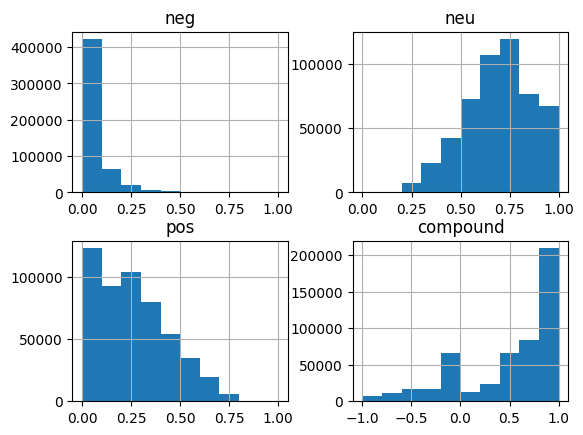

In [67]:
reviews.hist();

Как видим, признаки расположены ненормально(кроме *neu*), поэтому используем корреляцию Спирмена, чтобы посмотреть, есть ли среди них мультиколлинеарность.

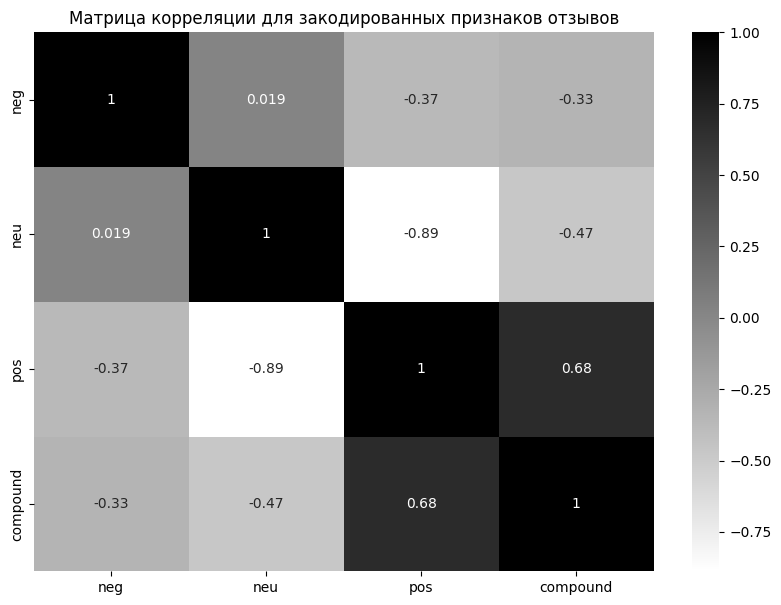

In [81]:
plt.figure(figsize=(10, 7))
corr_heatmap = sns.heatmap(reviews.corr(numeric_only=True, method='spearman'), annot=True, cmap='binary')
corr_heatmap.set_title('Матрица корреляции для закодированных признаков отзывов');

Наблюдается очень сильная отрицательная корреляция признаков *pos* и *neu*, равная $-0.89$. Логично будет удалить признак нейтральности отзыва, а не признак положительности. Добавим оставшиеся признаки к основному датафрейму и удалим строковые признаки с отзывами.

In [82]:
del polarity_score_keys[1] # удаляем имя признака neu из списка
hotels = pd.concat([hotels.drop(columns=all_reviews), reviews[polarity_score_keys]], axis=1)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population_ratio,distance_to_capital,is_capital,neg,pos,compound
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58887359,484.0,0,0.049,0.334,0.9924
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17797060,4.0,1,0.196,0.000,-0.2960
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,47615034,506.0,0,0.000,0.655,0.6908


## Анализ оставшихся категориальных признаков

Посмотрим, сколько категориальных признаков ещё осталось.

In [83]:
cat_hotels = hotels[[col for col in hotels.columns if hotels[col].dtype == 'object']].copy()
cat_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   review_date           515738 non-null  object
 1   hotel_name            515738 non-null  object
 2   reviewer_nationality  515738 non-null  object
 3   tags                  515738 non-null  object
 4   days_since_review     515738 non-null  object
 5   country               515738 non-null  object
dtypes: object(6)
memory usage: 23.6+ MB


* *review_date* - дата, когда рецензент разместил соответствующий отзыв.
* *days_since_review* - продолжительность между датой проверки и датой очистки.
* *reviewer_nationality* - национальность пользователя, оставившего отзыв.

Такие данные вряд ли положительно скажутся на модели предсказания рейтинга, поэтому на данном этапе удалим эти признаки. Если нас не будет удовлетворять точность построенной модели, то можем вернуться к этим признакам и попробовать их как-либо обработать.

In [84]:
cat_hotels.drop(columns=['review_date', 'days_since_review', 'reviewer_nationality'], inplace=True)
cat_hotels.head()

,hotel_name,tags,country
0,Hotel Da Vinci,"[' Leisure trip ', ' Couple ', ' Double Room '...",Italy
1,Urban Lodge Hotel,"[' Leisure trip ', ' Group ', ' Triple Room ',...",Netherlands
2,Alexandra Barcelona A DoubleTree by Hilton,"[' Business trip ', ' Solo traveler ', ' Twin ...",Spain
3,Hotel Principe Di Savoia,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",Italy
4,Hotel Esther a,"[' Business trip ', ' Solo traveler ', ' Class...",Netherlands


Посмотрим, сколько уникальных значений в признаках *hotel_name* и *country*.

In [85]:
cat_hotels[['hotel_name', 'country']].nunique()

hotel_name    1492
country          7
dtype: int64

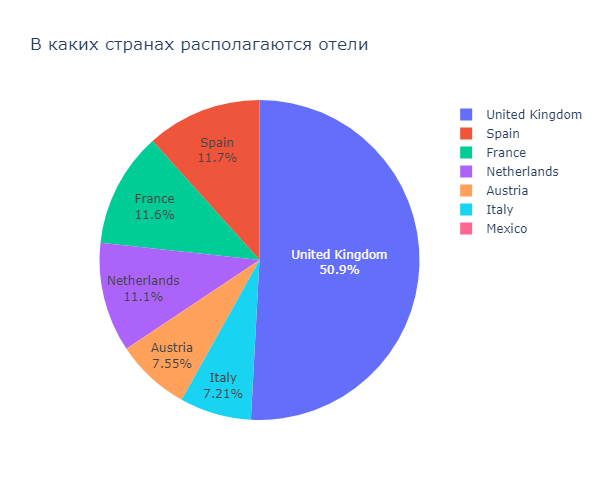

In [90]:
countries_bar = px.pie(
    cat_hotels.sort_values(by='country'),
    names='country',
    width=600,
    height=500,
    title='В каких странах располагаются отели'
)
countries_bar.update_traces(textposition='inside', textinfo='percent+label')

## Кодируем оставшиеся категориальные признаки

Оба признака являются номинальными. Для *hotel_name* будем использовать BinaryEncoder, т.к. значений слишком много. Для *country* подойдёт OneHotEncoder, это создаст всего 7 доп.признаков.

In [91]:
bin_encoder = ce.BinaryEncoder()
encoded_hotel_names = bin_encoder.fit_transform(cat_hotels['hotel_name'])
encoded_hotel_names.head()

,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,1


In [92]:
one_hot_encoder = ce.OneHotEncoder(use_cat_names=True)
encoded_country = one_hot_encoder.fit_transform(cat_hotels['country'])
encoded_country.head()

,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,country_Mexico
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0


Для признака *tags* воспользуемся другим подходом и сделаем из него числовой признак. Для начала распакуем из каждой строки все тэги, после чего посчитаем количество уникальных для всех строк во всём датафрейме.

In [93]:
def clean_tags(tags:str) -> list:
    stop_chars = ['[', ']', '\' ', ' \'']
    for char in stop_chars:
        tags = tags.replace(char, '')
    return tags.split(', ')
print('Количество уникальных тэгов:', cat_hotels['tags'].apply(clean_tags).explode().nunique())
cleaned_tags = pd.DataFrame(cat_hotels['tags'].apply(clean_tags))
cleaned_tags

Количество уникальных тэгов: 2428


,tags
0,"[Leisure trip, Couple, Double Room, Stayed 2 n..."
1,"[Leisure trip, Group, Triple Room, Stayed 1 ni..."
2,"[Business trip, Solo traveler, Twin Room, Stay..."
3,"[Leisure trip, Couple, Ambassador Junior Suite..."
4,"[Business trip, Solo traveler, Classic Double ..."
...,...
515733,"[Leisure trip, Group, Club Double or Twin Room..."
515734,"[Leisure trip, Couple, Standard Double Room, S..."
515735,"[Business trip, Solo traveler, Single Room, St..."
515736,"[Leisure trip, Solo traveler, Deluxe Double Ro..."


Можем создать признак "Количество самых популярных тэгов в строке". Под "самыми популярными" будем считать, что тэг входит в топ-50 по их количеству во всём датасете. В данном случае у нас получается порядковое кодирование, где чем выше число - тем больше популярных тэгов содержится в строке. Возможно, для модели эта информация будет иметь вес.

In [94]:
top_tags = cleaned_tags['tags'].explode().value_counts().head(50).index

def count_popular(tags:list):
    counter = 0
    for tag in tags:
        if tag in top_tags:
            counter += 1 
    return counter

def count_tags(tags:list):
    return len(tags)

encoded_tags = cleaned_tags['tags'].apply(count_tags)
encoded_tags.name = 'tags_count'
encoded_tags

0         4
1         4
2         5
3         4
4         5
         ..
515733    5
515734    5
515735    4
515736    4
515737    4
Name: popular_tags_count, Length: 515738, dtype: int64

Объединим закодированные категориальные признаки (кроме *tags*, т.к. он стал числовым и обозначает количество) в один датафрейм.

In [95]:
encoded_cats = pd.concat([encoded_hotel_names, encoded_country], axis=1)
encoded_cats

,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,country_Mexico
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0
515734,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0
515735,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
515736,0,0,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0


Проверим признаки на мультиколлинеарность с помощью матрицы корреляции Спирмена (для категориальных значений).

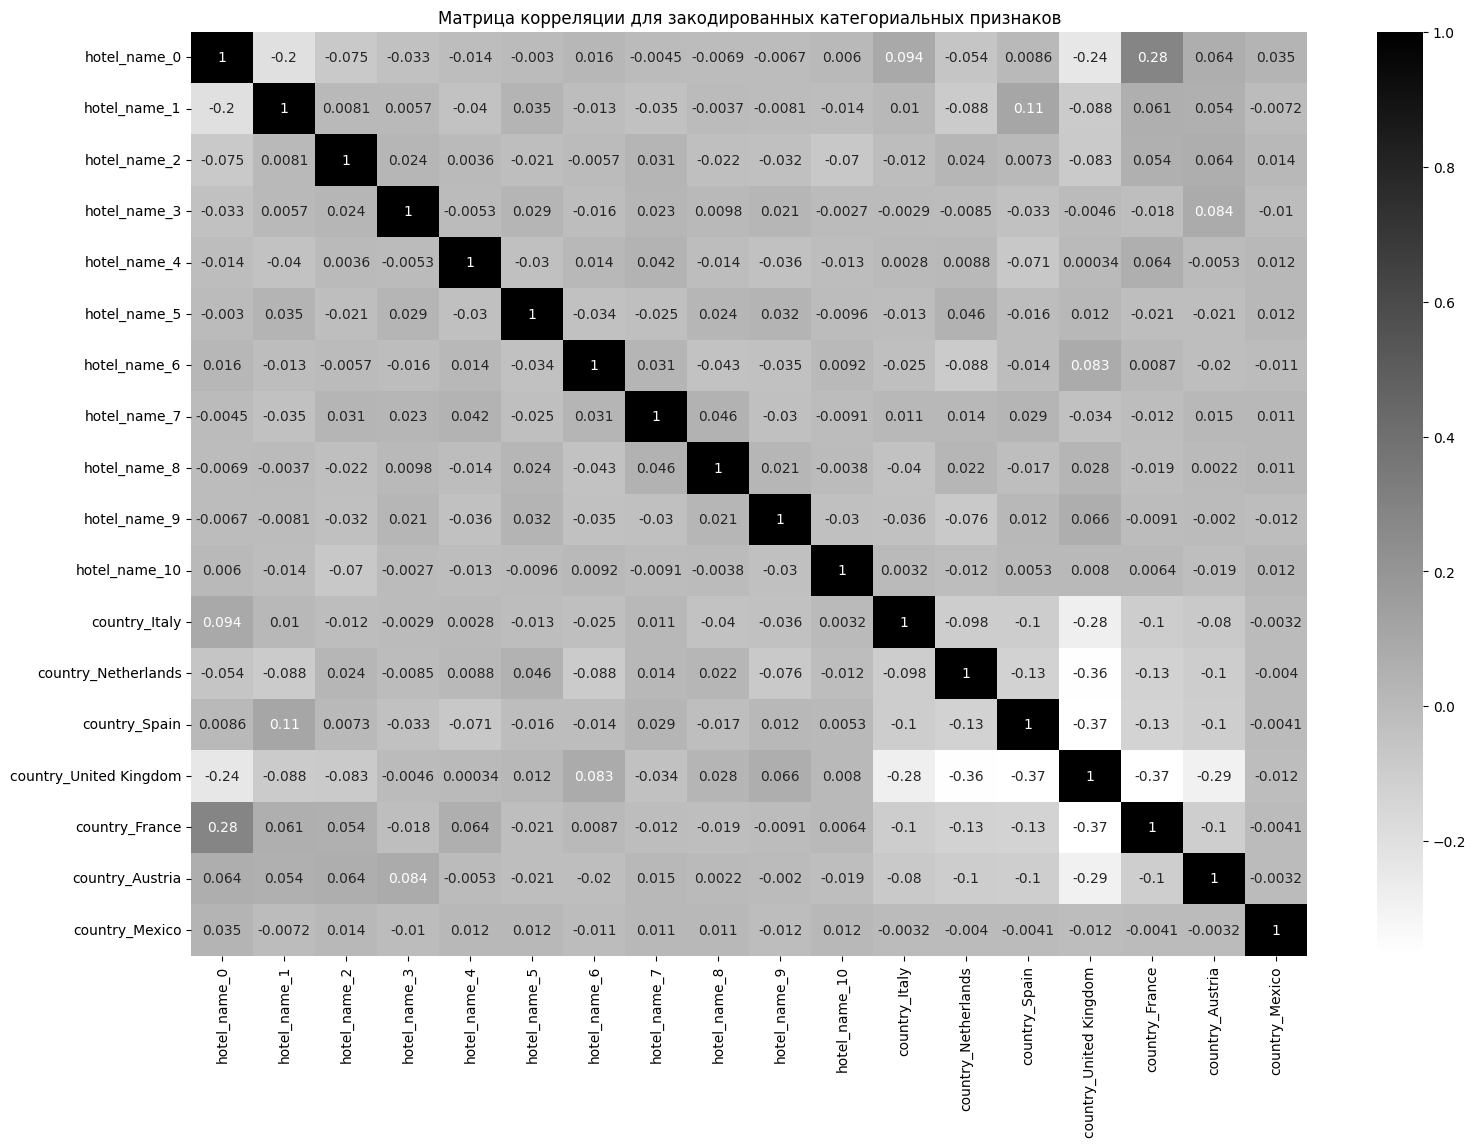

In [97]:
plt.figure(figsize=(18, 12))
corr_heatmap = sns.heatmap(encoded_cats.corr(method='spearman'), annot=True, cmap='binary')
corr_heatmap.set_title('Матрица корреляции для закодированных категориальных признаков');

Мультиколлинеарность не наблюдается, оставим в таком виде.

## Анализ числовых признаков

Теперь проверим все числовые признаки на мультиколлинеарность.

In [98]:
extra_cols = polarity_score_keys.copy()
# Не будем использовать уже проанализированные признаки закодированных отзывов, целевой столбец, индикатор train/test и индикатор столицы
extra_cols.extend(['sample', 'reviewer_score', 'is_capital'])
num_hotels = pd.concat([
    hotels[[col for col in hotels.columns if hotels[col].dtype != 'object']].drop(columns=extra_cols),
    encoded_tags
    ], axis=1)
num_hotels.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,population_ratio,distance_to_capital,popular_tags_count
0,904,8.1,52,16670,62,1,58887359,484.0,4
1,612,8.6,10,5018,0,7,17797060,4.0,4
2,46,8.3,3,351,5,15,47615034,506.0,5
3,241,9.1,0,1543,27,9,58887359,478.0,4
4,834,9.1,0,4687,7,2,17797060,0.0,5


Построим гистограмму и определим, как распределены данные признаки.

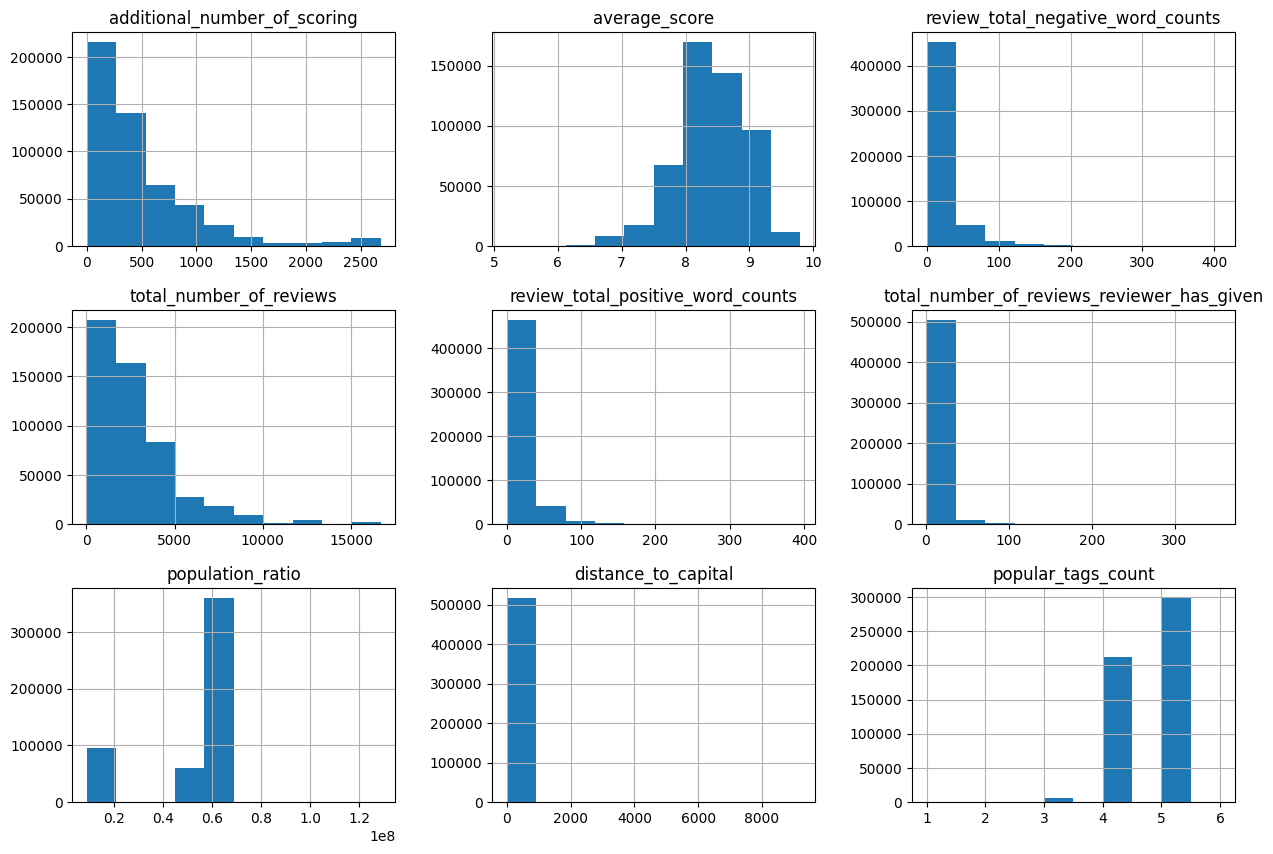

In [99]:
num_hotels.hist(figsize=(15, 10));

На нормальное распределение похож только 1 признак - *average_score*. Корреляция Пирсона не подходит, будем использовать Спирмана.

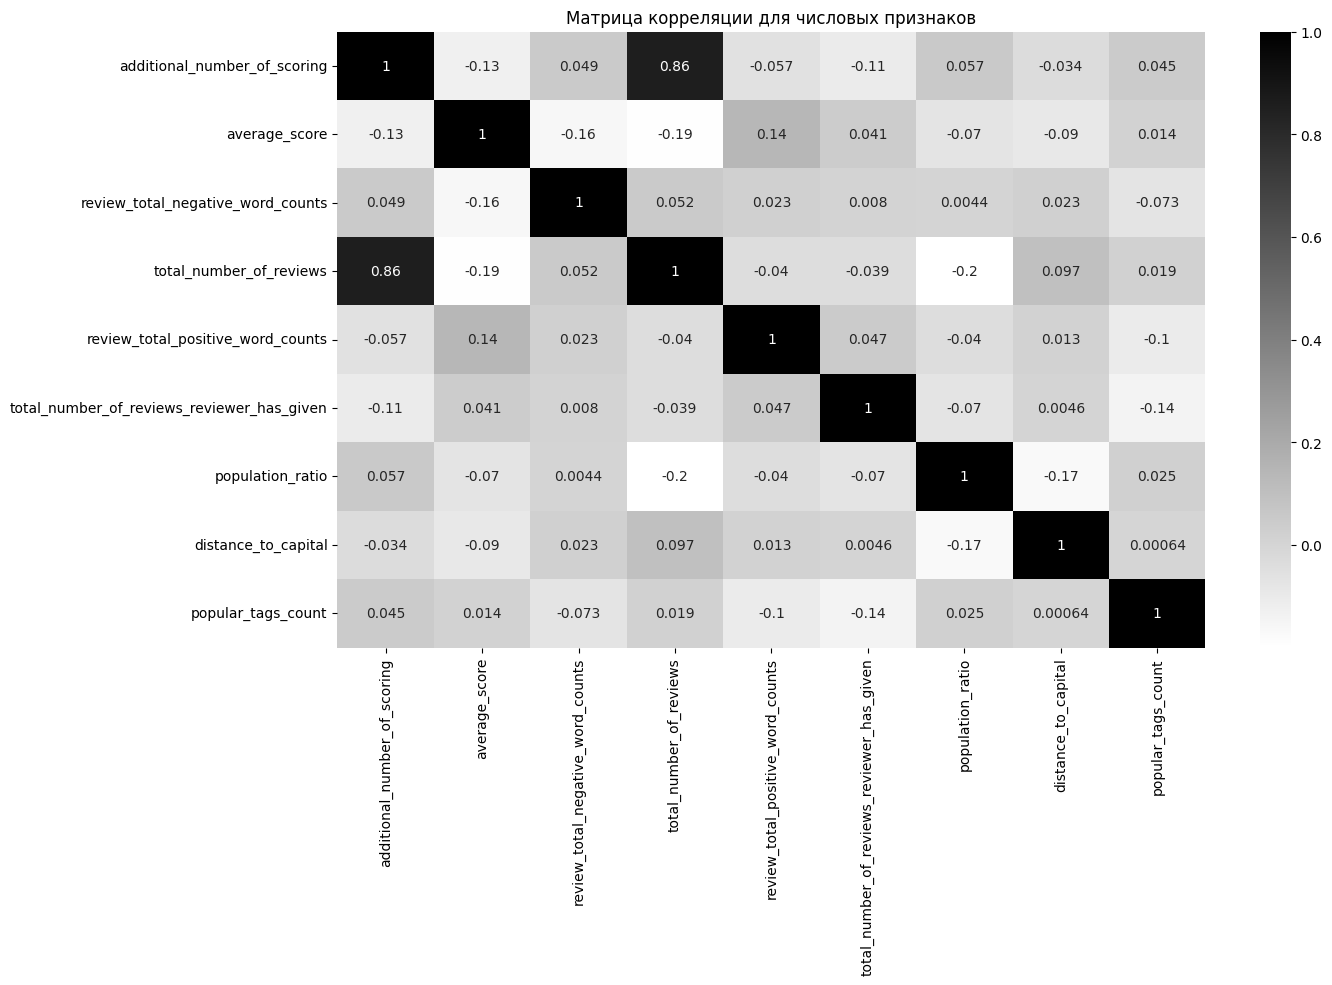

In [102]:
plt.figure(figsize=(14, 8))
corr_heatmap = sns.heatmap(num_hotels.corr(method='spearman'), cmap='binary', annot=True)
corr_heatmap.set_title('Матрица корреляции для числовых признаков');

Наблюдается сильная корреляция между признаками *additional_number_of_scoring* и *total_number_of_reviews*. Будет целесообразно удалить *additional_number_of_scoring*, т.к. это значение показывает, сколько гостей отеля поставили оценку, но не оставили отзыв.

In [103]:
num_hotels.drop(columns='additional_number_of_scoring', inplace=True)

## Объединим все созданные и числовые признаки в один датафрейм.

In [104]:
hotels_encoded = pd.concat([
    num_hotels,
    encoded_cats,
    hotels[extra_cols]
], axis=1)
hotels_encoded.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,population_ratio,distance_to_capital,popular_tags_count,hotel_name_0,hotel_name_1,...,country_United Kingdom,country_France,country_Austria,country_Mexico,neg,pos,compound,sample,reviewer_score,is_capital
0,8.1,52,16670,62,1,58887359,484.0,4,0,0,...,0,0,0,0,0.049,0.334,0.9924,0,0.0,0
1,8.6,10,5018,0,7,17797060,4.0,4,0,0,...,0,0,0,0,0.196,0.000,-0.2960,0,0.0,1
2,8.3,3,351,5,15,47615034,506.0,5,0,0,...,0,0,0,0,0.000,0.655,0.6908,0,0.0,0
3,9.1,0,1543,27,9,58887359,478.0,4,0,0,...,0,0,0,0,0.000,0.368,0.9153,0,0.0,0
4,9.1,0,4687,7,2,17797060,0.0,5,0,0,...,0,0,0,0,0.000,0.691,0.7717,0,0.0,1


In [105]:
hotels_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   population_ratio                            515738 non-null  int64  
 6   distance_to_capital                         515738 non-null  float64
 7   popular_tags_count                          515738 non-null  int64  
 8   hotel_name_0                                515738 non-null  int64  
 9   hotel_name_1                                515738 non-null  int64  
 

Все наши признаки теперь являются числами и могут быть поданы в модель для обучения.

Взглянем на матрицу корреляции для всего датафрейма, на который будет использоваться для обучения модели.

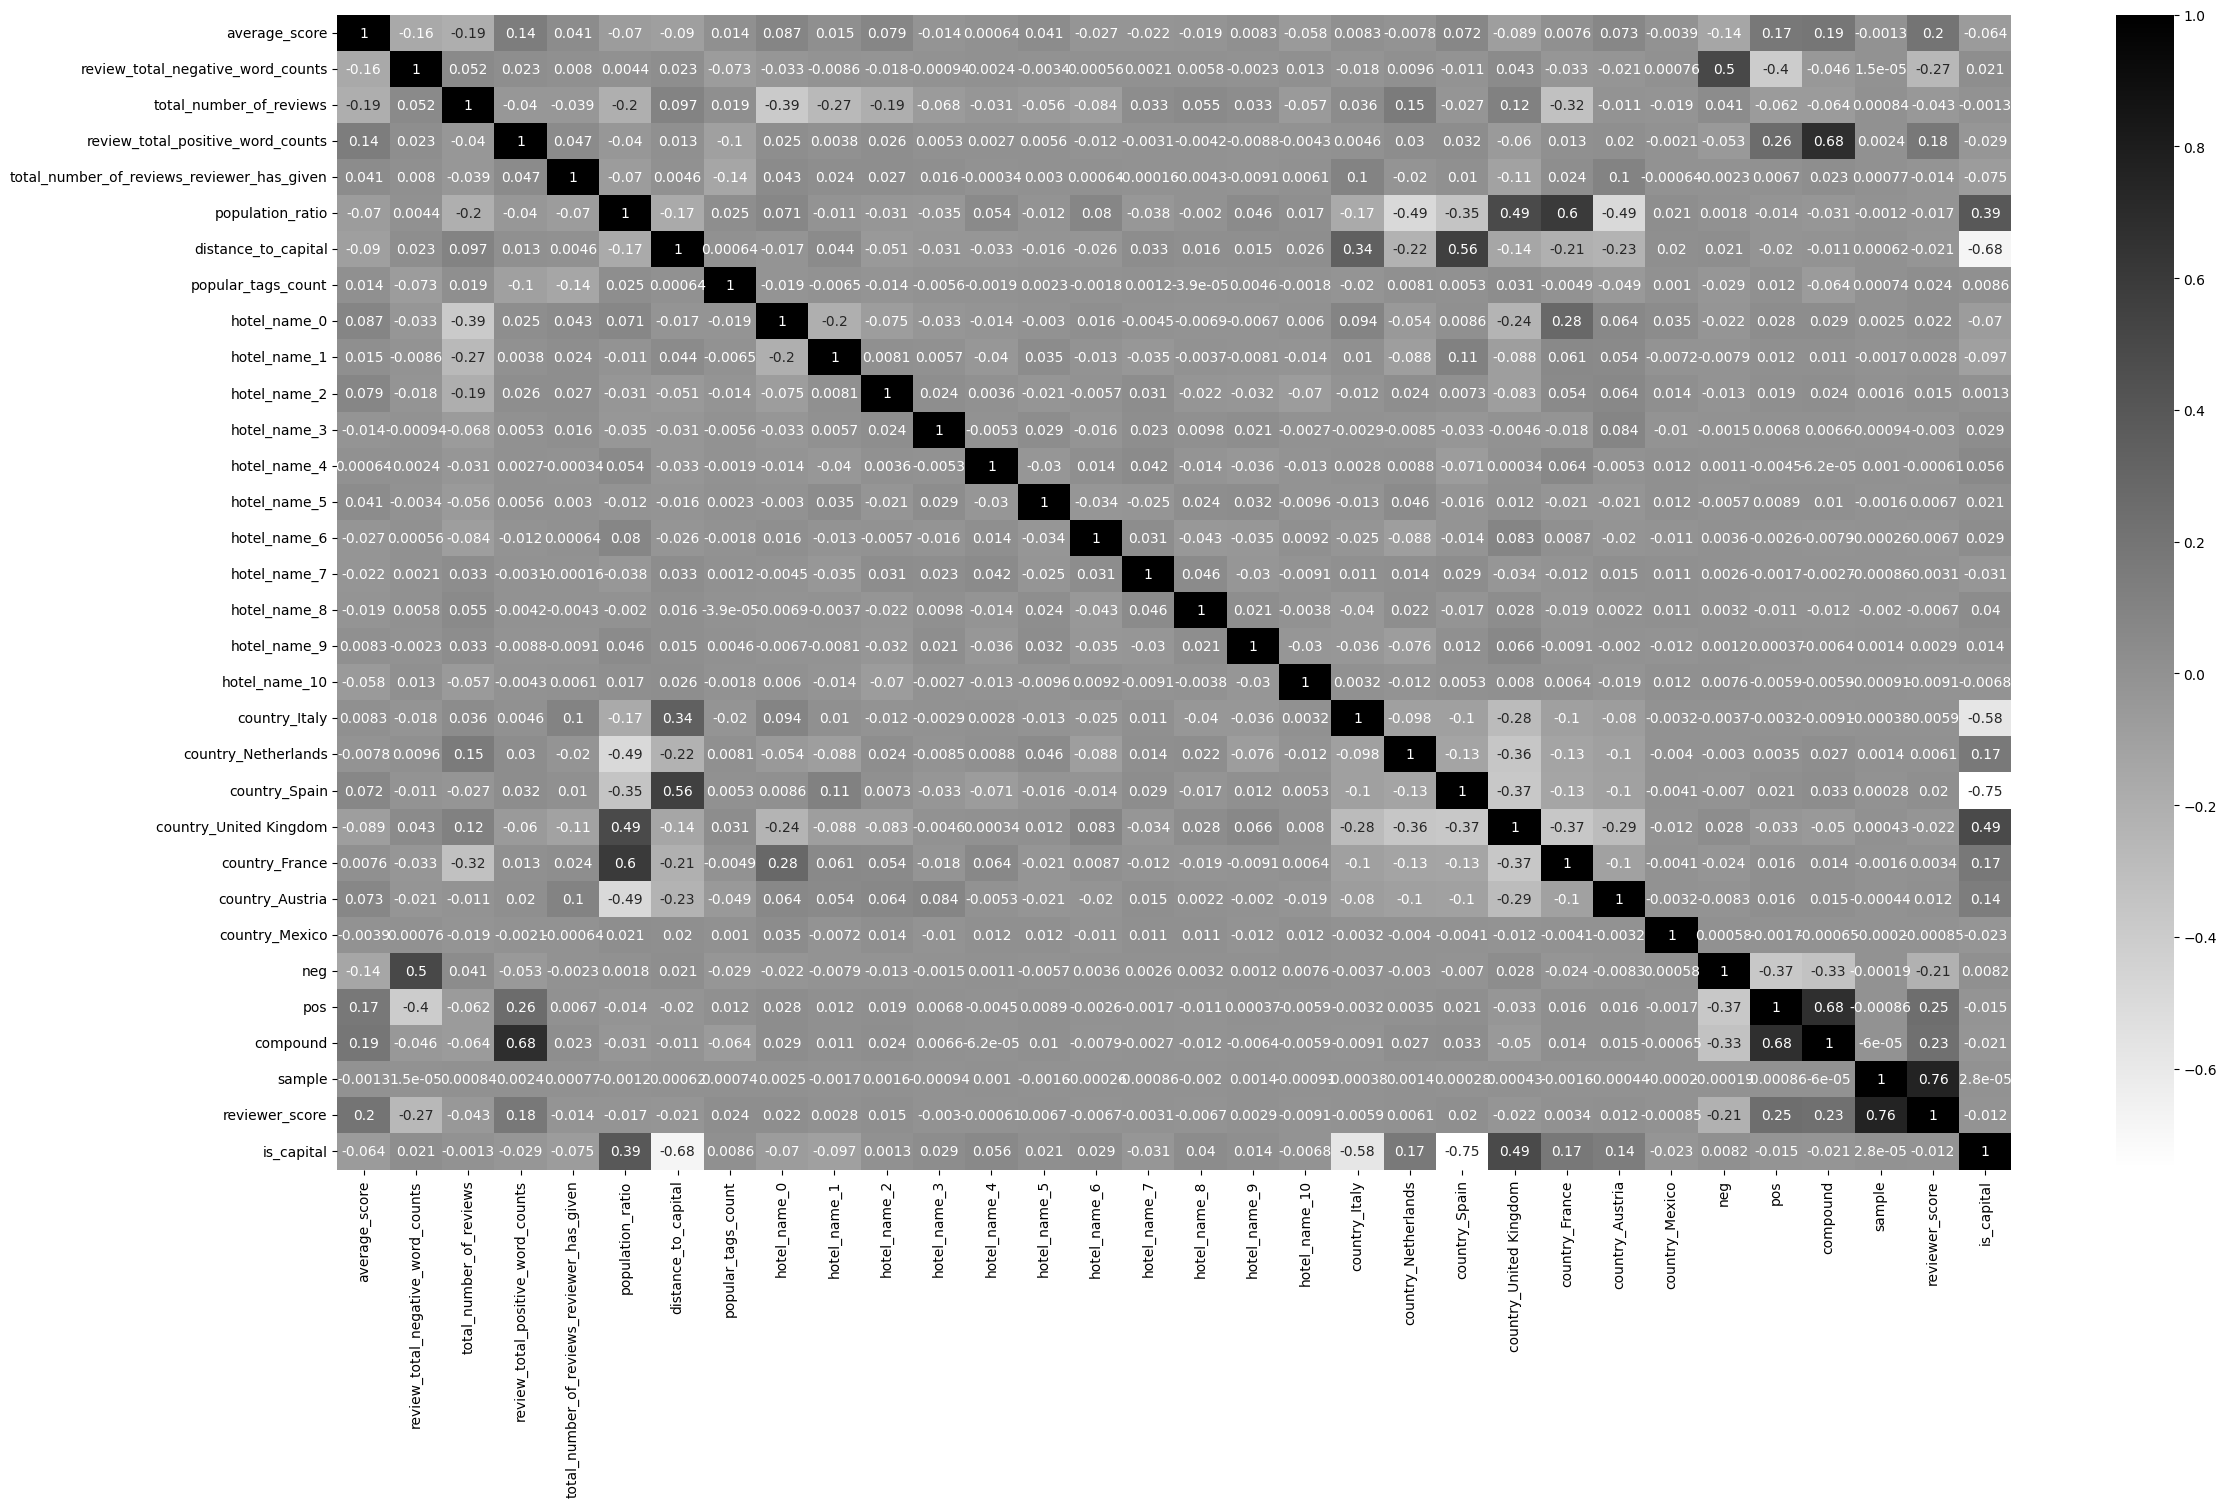

In [106]:
plt.figure(figsize=(27, 15))
corr_heatmap = sns.heatmap(hotels_encoded.corr(method='spearman'), annot=True, cmap='binary');

Мультиколлинеарность не наблюдается между признаками. *sample* и *reviewer_score* не учитываем, т.к. *sample* - индикатор данных, а *reviewer_score* - целевой признак.

In [107]:
# # Сохраним данные в файл
# hotels_encoded.to_csv('data/hotels_encoded_v2.csv')

## Создадим модель на подготовленном датафрейме и проверим её точность

In [110]:
# Фиксируем для воспроизводимости
RANDOM_SEED = 42

In [116]:
train_data = hotels_encoded[hotels_encoded['sample'] == 1].drop(columns='sample')
test_data = hotels_encoded[hotels_encoded['sample'] == 0].drop(columns='sample')

X = train_data.drop(columns='reviewer_score')
y = train_data['reviewer_score']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 31), (386803, 31), (386803, 30), (309442, 30), (77361, 30))

In [118]:
# Создаём модель  
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
      
# Обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


In [119]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12773889708823769


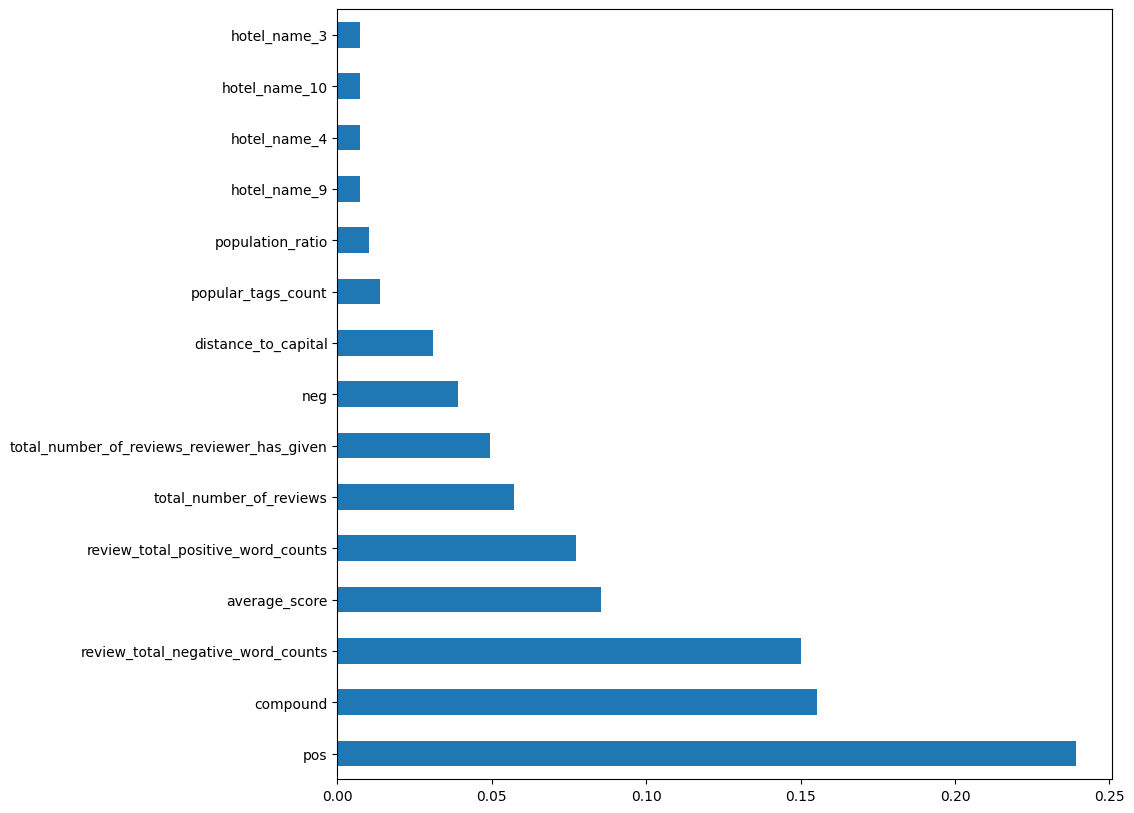

In [121]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [123]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,population_ratio,distance_to_capital,popular_tags_count,hotel_name_0,hotel_name_1,...,country_Spain,country_United Kingdom,country_France,country_Austria,country_Mexico,neg,pos,compound,reviewer_score,is_capital
75073,8.7,9,2332,63,1,67026292,11.0,4,0,1,...,0,1,0,0,0,0.000,0.359,0.9854,0.0,1
127669,7.8,21,5726,20,2,67026292,4.0,4,0,0,...,0,1,0,0,0,0.000,0.325,0.9312,0.0,1
124627,8.3,0,974,49,6,17797060,2.0,4,0,0,...,0,0,0,0,0,0.000,0.320,0.9572,0.0,1
27608,9.3,53,520,3,1,47615034,507.0,5,0,1,...,1,0,0,0,0,0.190,0.158,-0.0018,0.0,0
95934,6.8,13,2751,10,2,67026292,2.0,5,0,0,...,0,1,0,0,0,0.000,0.507,0.9246,0.0,1
99784,7.9,2,6511,2,4,68042591,3.0,5,0,0,...,0,0,1,0,0,0.000,0.000,0.0000,0.0,1
36506,8.4,72,3445,51,11,58887359,477.0,4,0,0,...,0,0,0,0,0,0.067,0.093,0.3380,0.0,0
6598,8.4,40,1925,23,5,17797060,2.0,5,0,0,...,0,0,0,0,0,0.028,0.155,0.8500,0.0,1
49218,8.9,20,857,18,1,67026292,1.0,5,0,0,...,0,1,0,0,0,0.000,0.248,0.8357,0.0,1
8541,8.5,2,4032,7,2,17797060,1.0,5,0,0,...,0,0,0,0,0,0.000,0.000,0.0000,0.0,1


In [124]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [122]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [125]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


In [127]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission_final.csv', index=False)
sample_submission.head(10)


,reviewer_score,id
0,8.779,488440
1,7.693,274649
2,8.854,374688
3,9.823,404352
4,9.620,451596
5,8.723,302161
6,7.825,317079
7,7.750,13963
8,8.760,159785
9,7.651,195089
